In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
%matplotlib inline

In [2]:
pip install openpyxl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.1/242.1 kB 460.9 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
df=pd.read_excel('../input/penex/Penex_status.xlsx',header=None)

In [4]:
def single(x):
    if x=='Single Rx':
        return 1
    else:
        return 0     
    

In [5]:
df.columns=df.iloc[0:3].fillna('').apply(' '.join).str.strip()
df=df.iloc[4:]
df.columns=df.columns.str.replace(" ","_")
df.columns=df.columns.str.lower()
df.columns=df.columns.str.replace("-","_")
df.reset_index(drop=True, inplace=True)
df=df.replace('No Data',np.nan)
df=df.replace('No Lab Data',np.nan)
df=df.replace('-',np.nan)
df=df.replace('Nil',0)
df['fron_dd/mm/yyyy']=pd.to_datetime(df['fron_dd/mm/yyyy'])

In [6]:
df['single_reactor_mode']=df['lag_reactor_delta_temperatures_lag_ti#1/inlet_delta_°c'].apply(single)

In [7]:
df=df.replace('Single Rx',np.nan)

In [8]:
for column in df.columns:
    try:
        df[column]=df[column].astype(float)
    except:
        continue

In [9]:
df.drop([2069,2070,2071,2072,2073],axis=0, inplace=True) # wrong date

In [10]:
df['Dt_lead']=df['lead_reactor_delta_temperatures_lead_ti#1/inlet_delta_°c']+df['lead_reactor_delta_temperatures_lead_ti#2/ti#1_delta_°c']+df['lead_reactor_delta_temperatures_lead_ti#3/ti#2_delta_°c']+df['lead_reactor_delta_temperatures_lead_ti#4/ti#3_delta_°c']+df['lead_reactor_delta_temperatures_lead_outlet/ti#4_delta_°c'] 

In [11]:
df['Dt_lag']=df['lag_reactor_delta_temperatures_lag_ti#1/inlet_delta_°c']+df['lag_reactor_delta_temperatures_lag_ti#2/ti#1_delta_°c']+df['lag_reactor_delta_temperatures_lag_ti#3/ti#2_delta_°c']+df['lag_reactor_delta_temperatures_lag_ti#4/ti#3_delta_°c']+df['lag_reactor_delta_temperatures_lag_outlet/ti#4_delta_°c'] 

In [12]:
#df.resample('m',on='fron_dd/mm/yyyy')['Dt_lag'].mean()

# Starting to prepare the features

#### 1.choosing and removing nan

In [13]:
x_columns=df.columns[df.columns.str.contains('combined_feed_x_factor|Dt_|combined_feed_sm3/hr|combined_feed_s.g._@_base|reactor_product_ratios|reactor_temperatures_lead_inlet|lag_reactor_temperatures_lag_inlet|lead_reactor_delta_temperatures_lead_')]

In [14]:
df.dropna(subset=['misc._performance_variables_stabilized_c5+_product_ron_(calc)'],inplace=True)

In [15]:
df.dropna(subset=x_columns,inplace=True)

In [16]:
df.reset_index(drop=True,inplace=True)

In [17]:
X=df[x_columns]

In [18]:
y=df['misc._performance_variables_stabilized_c5+_product_ron_(calc)']

In [19]:
data=pd.merge(X,y,left_index=True,right_index=True)

#### 2.Checking distribution of the data

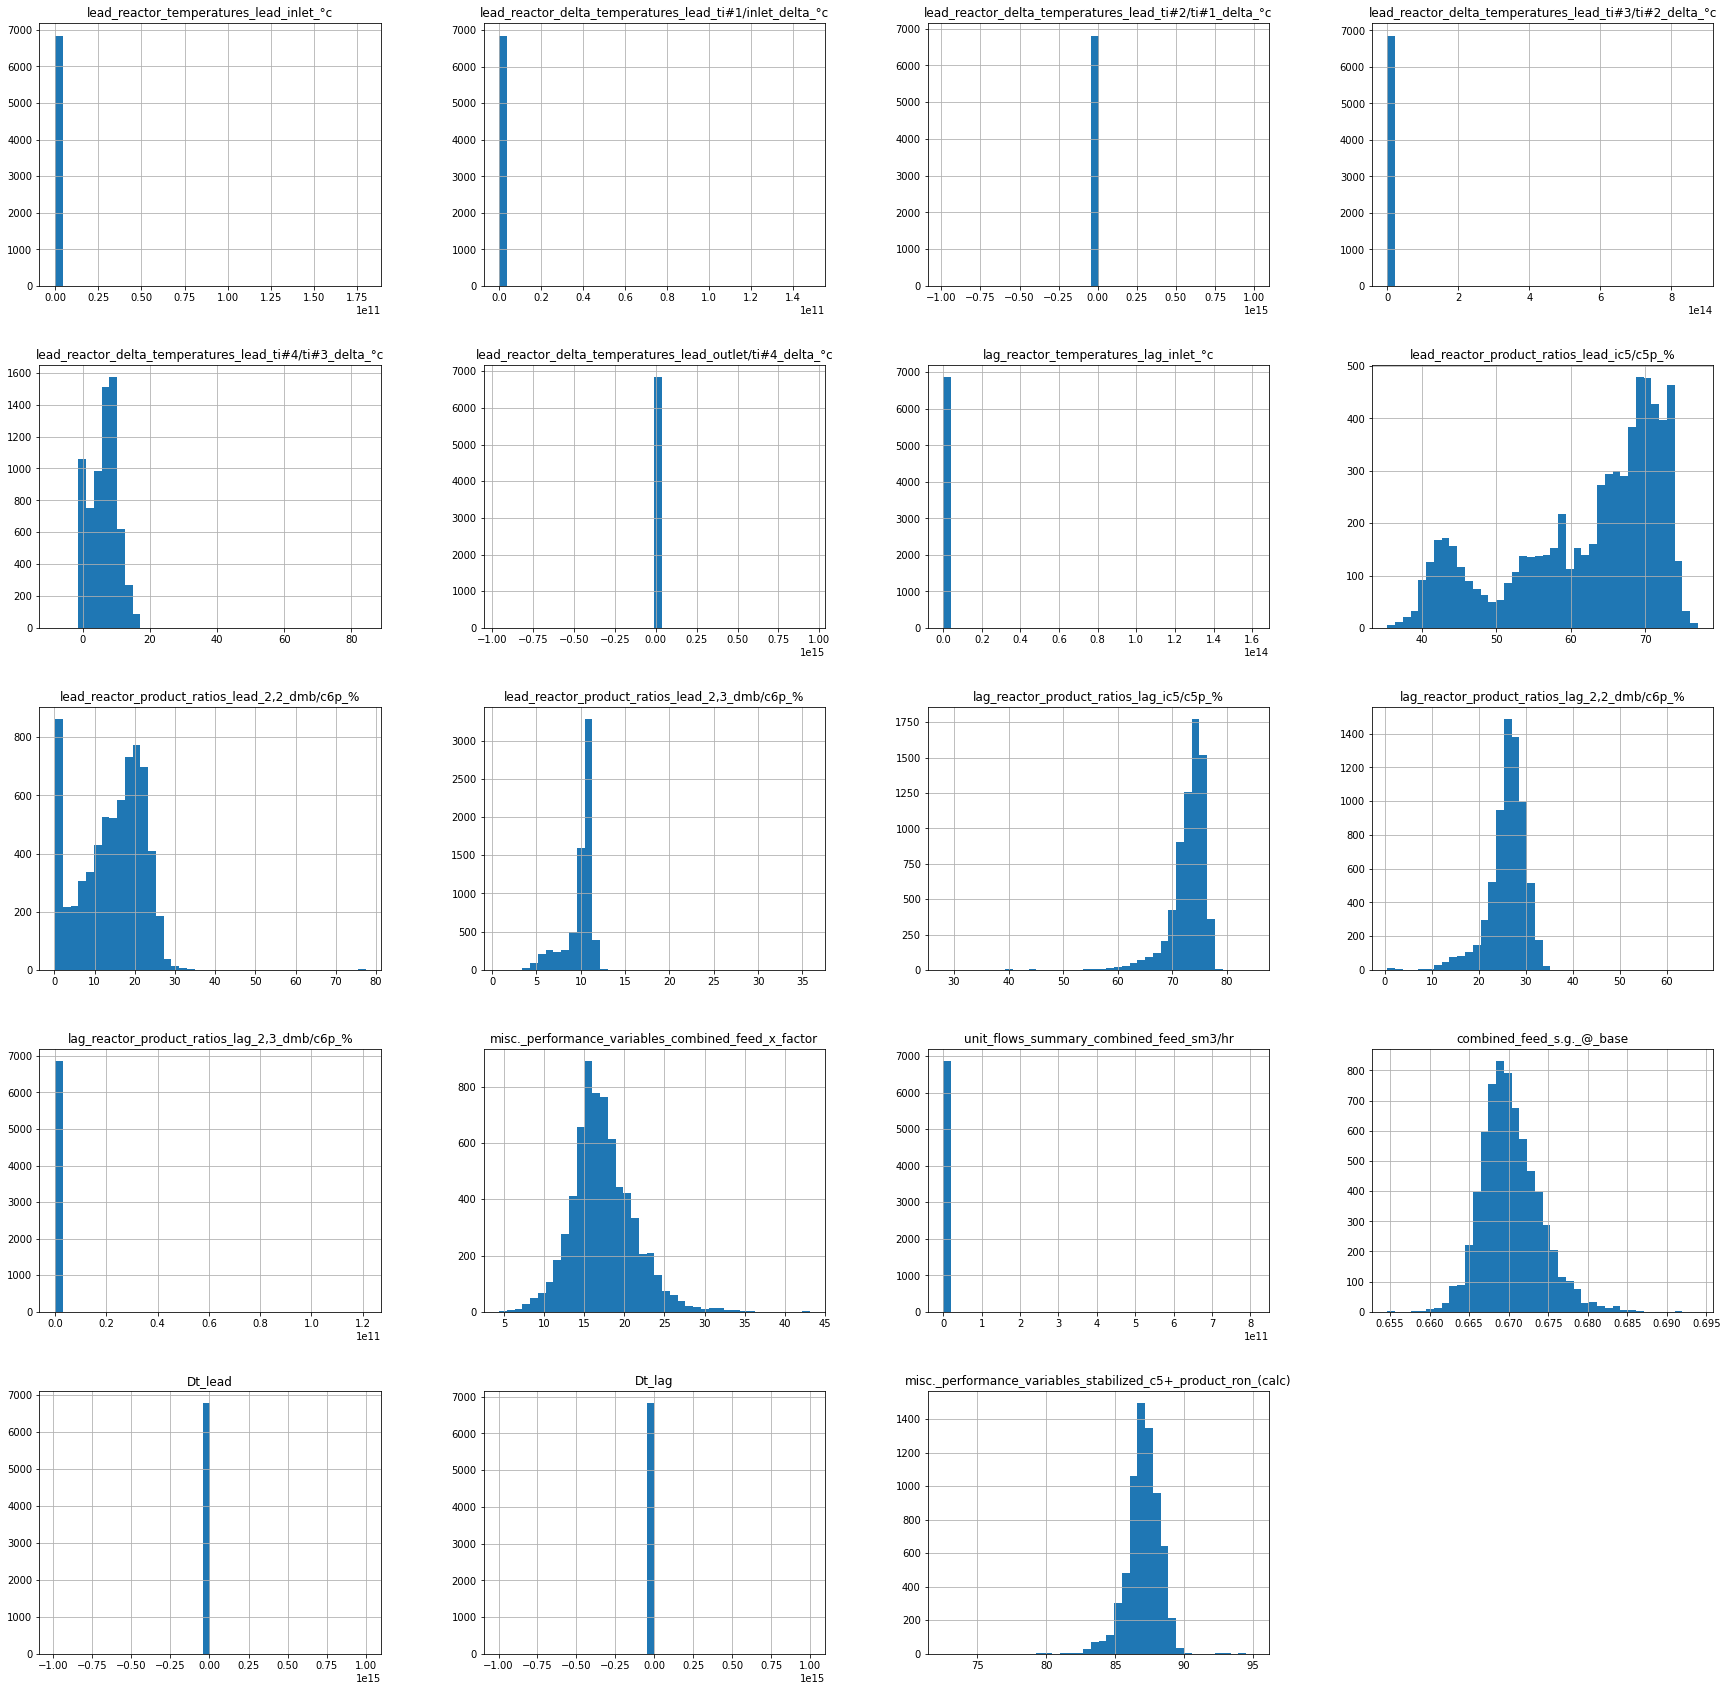

In [20]:
data.hist(figsize=(30,30),bins=40);    

#### 3. Checking data outliers and remove them

In [21]:
def outlier_columns(df,a=4):
    z_scores = stats.zscore(df[df.describe().columns])
    z_scores.fillna(0,inplace=True)
    abs_z_scores = np.abs(z_scores)
    (abs_z_scores>a).any(axis=0)
    outliers_columns=abs_z_scores.columns[(abs_z_scores>a).any(axis=0)]
    return df[outliers_columns]

def plotting(df):
    for i in df.columns:
        try:
            fig, ax = plt.subplots(figsize=(7,3))
            ax.plot(df[i])
            ax.set_ylabel(i)
            ax.set_xlabel('days')
            plt.xticks(rotation=45)
            plt.show()
        except:
            pass
        
def df_without_outliers (df,a=4):    
    z_scores = stats.zscore(df.iloc[:,:])
    z_scores.fillna(0,inplace=True)   # in case one column is filled with nan values
    abs_z_scores = np.abs(z_scores)
    filtered_entries = (abs_z_scores < a).all(axis=1)
    df_without_outliers = df[filtered_entries]
    return df_without_outliers

In [22]:
data.describe()

,lead_reactor_temperatures_lead_inlet_°c,lead_reactor_delta_temperatures_lead_ti#1/inlet_delta_°c,lead_reactor_delta_temperatures_lead_ti#2/ti#1_delta_°c,lead_reactor_delta_temperatures_lead_ti#3/ti#2_delta_°c,lead_reactor_delta_temperatures_lead_ti#4/ti#3_delta_°c,lead_reactor_delta_temperatures_lead_outlet/ti#4_delta_°c,lag_reactor_temperatures_lag_inlet_°c,lead_reactor_product_ratios_lead_ic5/c5p_%,"lead_reactor_product_ratios_lead_2,2_dmb/c6p_%","lead_reactor_product_ratios_lead_2,3_dmb/c6p_%",lag_reactor_product_ratios_lag_ic5/c5p_%,"lag_reactor_product_ratios_lag_2,2_dmb/c6p_%","lag_reactor_product_ratios_lag_2,3_dmb/c6p_%",misc._performance_variables_combined_feed_x_factor,unit_flows_summary_combined_feed_sm3/hr,combined_feed_s.g._@_base,Dt_lead,Dt_lag,misc._performance_variables_stabilized_c5+_product_ron_(calc)
count,6.858000e+03,6.858000e+03,6.858000e+03,6.858000e+03,6858.000000,6.858000e+03,6.858000e+03,6858.000000,6858.000000,6858.000000,6858.000000,6858.000000,6.858000e+03,6858.000000,6.858000e+03,6858.000000,6.858000e+03,6.858000e+03,6858.000000
mean,3.237405e+08,3.691195e+07,2.164341e+11,1.276755e+11,6.125625,3.058639e+11,2.393475e+10,62.016128,14.280568,9.955942,72.996314,26.103690,1.589376e+08,17.370015,1.343196e+08,0.670299,6.500103e+11,1.579701e+11,87.032496
std,7.438459e+09,2.017055e+09,4.953964e+13,1.057319e+13,4.051523,4.455335e+13,1.942408e+12,10.234281,7.854596,1.739117,3.370433,4.016094,4.384807e+09,3.917221,9.860312e+09,0.003741,6.760202e+13,4.261275e+13,1.214508
min,0.000000e+00,-8.534227e+02,-9.876952e+14,-4.727066e+01,-8.342631,-9.580849e+14,0.000000e+00,35.403727,0.172414,0.793651,28.037383,0.573614,7.168459e-01,4.400000,-7.357897e-02,0.654659,-9.876952e+14,-9.961867e+14,72.513570
25%,1.250748e+02,6.363938e+00,7.840945e-01,-2.452394e-01,2.930401,-2.592274e+00,1.149961e+02,55.399061,8.493590,9.717314,71.804925,24.440748,1.040650e+01,14.962500,1.015595e+02,0.667816,1.670060e+01,6.624382e+00,86.409572
50%,1.439981e+02,9.729350e+00,4.354419e+00,1.709404e+00,6.583726,-1.248456e+00,1.200176e+02,65.465772,15.659166,10.494753,73.728814,26.607100,1.064163e+01,16.900000,1.095278e+02,0.669897,2.343694e+01,7.980661e+00,87.087883
75%,1.550483e+02,1.270240e+01,9.031296e+00,6.381318e+00,8.874934,8.139928e-02,1.283689e+02,70.224719,20.534224,10.843373,75.102041,28.622228,1.088136e+01,19.500000,1.164810e+02,0.672450,2.986028e+01,1.112002e+01,87.824446
max,1.797992e+11,1.481128e+11,9.977673e+14,8.755983e+14,84.247025,9.412685e+14,1.608558e+14,77.042802,77.397260,35.811836,84.888889,66.596639,1.211104e+11,43.100000,8.088127e+11,0.693920,9.977673e+14,9.972435e+14,95.056910


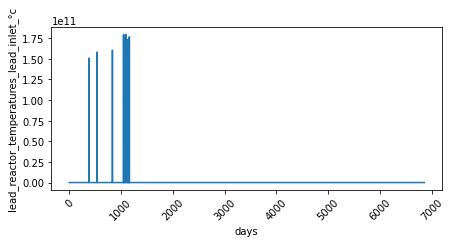

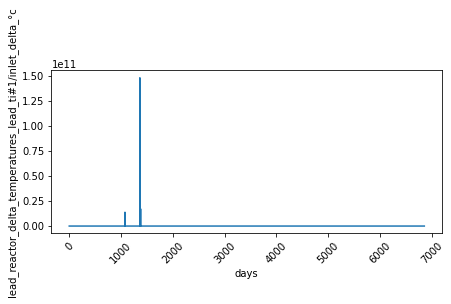

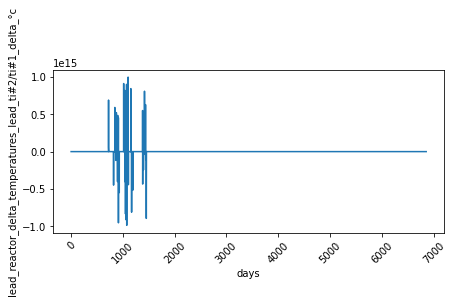

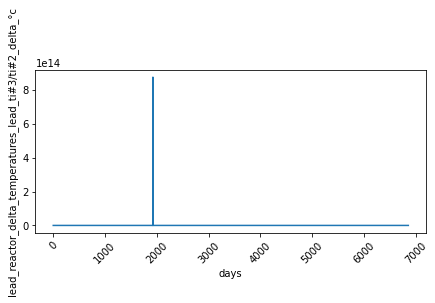

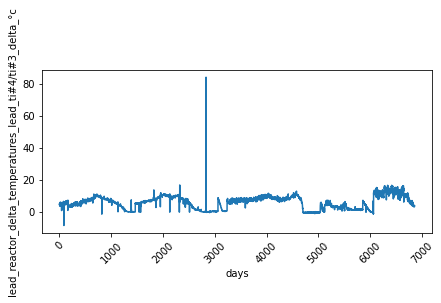

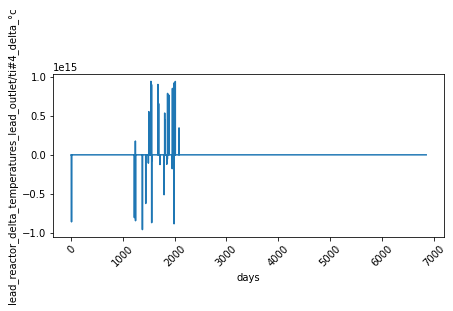

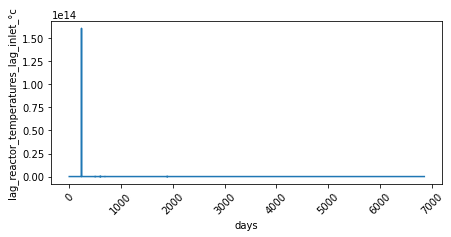

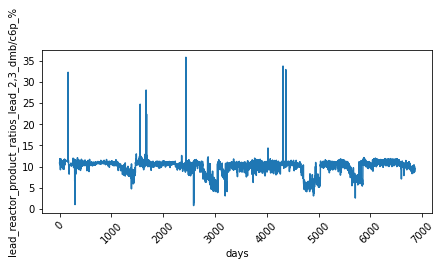

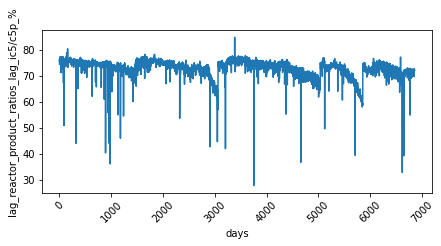

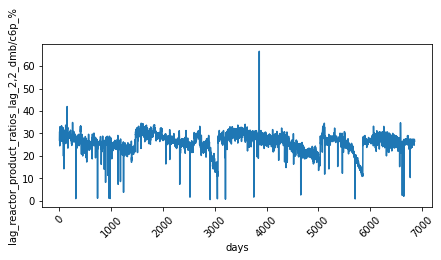

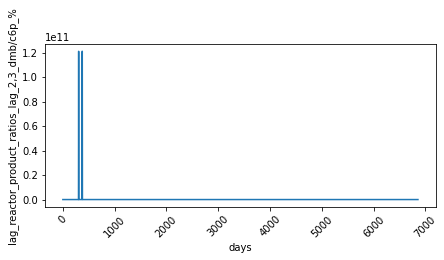

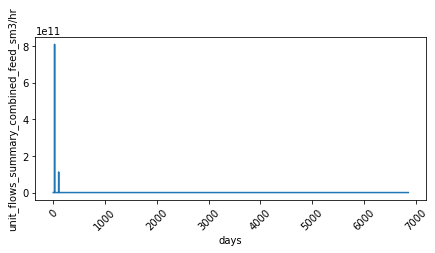

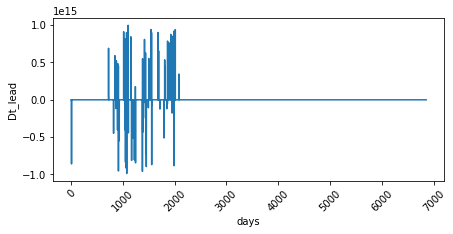

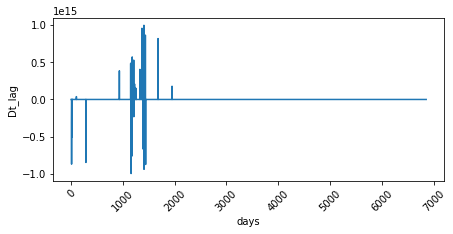

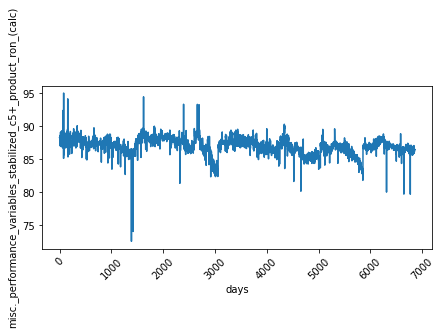

In [23]:
plotting(outlier_columns(data,10))

In [24]:
df_new=df_without_outliers(data,a=8).reset_index(drop=True)

In [25]:
#df_new.aggregate(['min','max'],axis=0)
df_new.describe().loc[['min','max'],:]

,lead_reactor_temperatures_lead_inlet_°c,lead_reactor_delta_temperatures_lead_ti#1/inlet_delta_°c,lead_reactor_delta_temperatures_lead_ti#2/ti#1_delta_°c,lead_reactor_delta_temperatures_lead_ti#3/ti#2_delta_°c,lead_reactor_delta_temperatures_lead_ti#4/ti#3_delta_°c,lead_reactor_delta_temperatures_lead_outlet/ti#4_delta_°c,lag_reactor_temperatures_lag_inlet_°c,lead_reactor_product_ratios_lead_ic5/c5p_%,"lead_reactor_product_ratios_lead_2,2_dmb/c6p_%","lead_reactor_product_ratios_lead_2,3_dmb/c6p_%",lag_reactor_product_ratios_lag_ic5/c5p_%,"lag_reactor_product_ratios_lag_2,2_dmb/c6p_%","lag_reactor_product_ratios_lag_2,3_dmb/c6p_%",misc._performance_variables_combined_feed_x_factor,unit_flows_summary_combined_feed_sm3/hr,combined_feed_s.g._@_base,Dt_lead,Dt_lag,misc._performance_variables_stabilized_c5+_product_ron_(calc)
min,0.000000,-8.534227e+02,-3.816185e+14,-18.396419,-8.342631,-2.416427e+14,0.000000e+00,35.403727,0.172414,0.793651,46.184739,1.151316,0.716846,4.4,-0.073579,0.654659,-3.816185e+14,-3.145876e+14,79.678202
max,1041.080349,1.379827e+10,2.375223e+14,84.058023,16.957667,3.449520e+14,1.472833e+11,77.042802,60.296846,15.838509,84.888889,41.995360,42.230347,43.1,219.113883,0.693920,3.449520e+14,2.151241e+14,95.056910


In [26]:
# repeat multible times untill the max and min are acceptables
df_new=df_without_outliers(df_new,a=4)
df_new.reset_index(drop=True,inplace=True)

In [27]:
df_new.describe().loc[['min','max'],:]

,lead_reactor_temperatures_lead_inlet_°c,lead_reactor_delta_temperatures_lead_ti#1/inlet_delta_°c,lead_reactor_delta_temperatures_lead_ti#2/ti#1_delta_°c,lead_reactor_delta_temperatures_lead_ti#3/ti#2_delta_°c,lead_reactor_delta_temperatures_lead_ti#4/ti#3_delta_°c,lead_reactor_delta_temperatures_lead_outlet/ti#4_delta_°c,lag_reactor_temperatures_lag_inlet_°c,lead_reactor_product_ratios_lead_ic5/c5p_%,"lead_reactor_product_ratios_lead_2,2_dmb/c6p_%","lead_reactor_product_ratios_lead_2,3_dmb/c6p_%",lag_reactor_product_ratios_lag_ic5/c5p_%,"lag_reactor_product_ratios_lag_2,2_dmb/c6p_%","lag_reactor_product_ratios_lag_2,3_dmb/c6p_%",misc._performance_variables_combined_feed_x_factor,unit_flows_summary_combined_feed_sm3/hr,combined_feed_s.g._@_base,Dt_lead,Dt_lag,misc._performance_variables_stabilized_c5+_product_ron_(calc)
min,74.554579,-93.568427,-1.180236e+13,-11.801471,-1.252937,-1.477157e+12,9.868164e+01,35.403727,0.172414,3.734440,61.111111,10.800000,7.768595,4.4,60.066069,0.655392,-1.180236e+13,-2.903308e+13,82.321581
max,188.119223,200.740684,2.770618e+01,14.367115,16.843335,4.292164e+02,1.587727e+10,77.042802,42.071882,15.838509,84.888889,34.895833,12.893553,32.6,139.799036,0.684756,3.326686e+02,4.216569e+01,90.938683


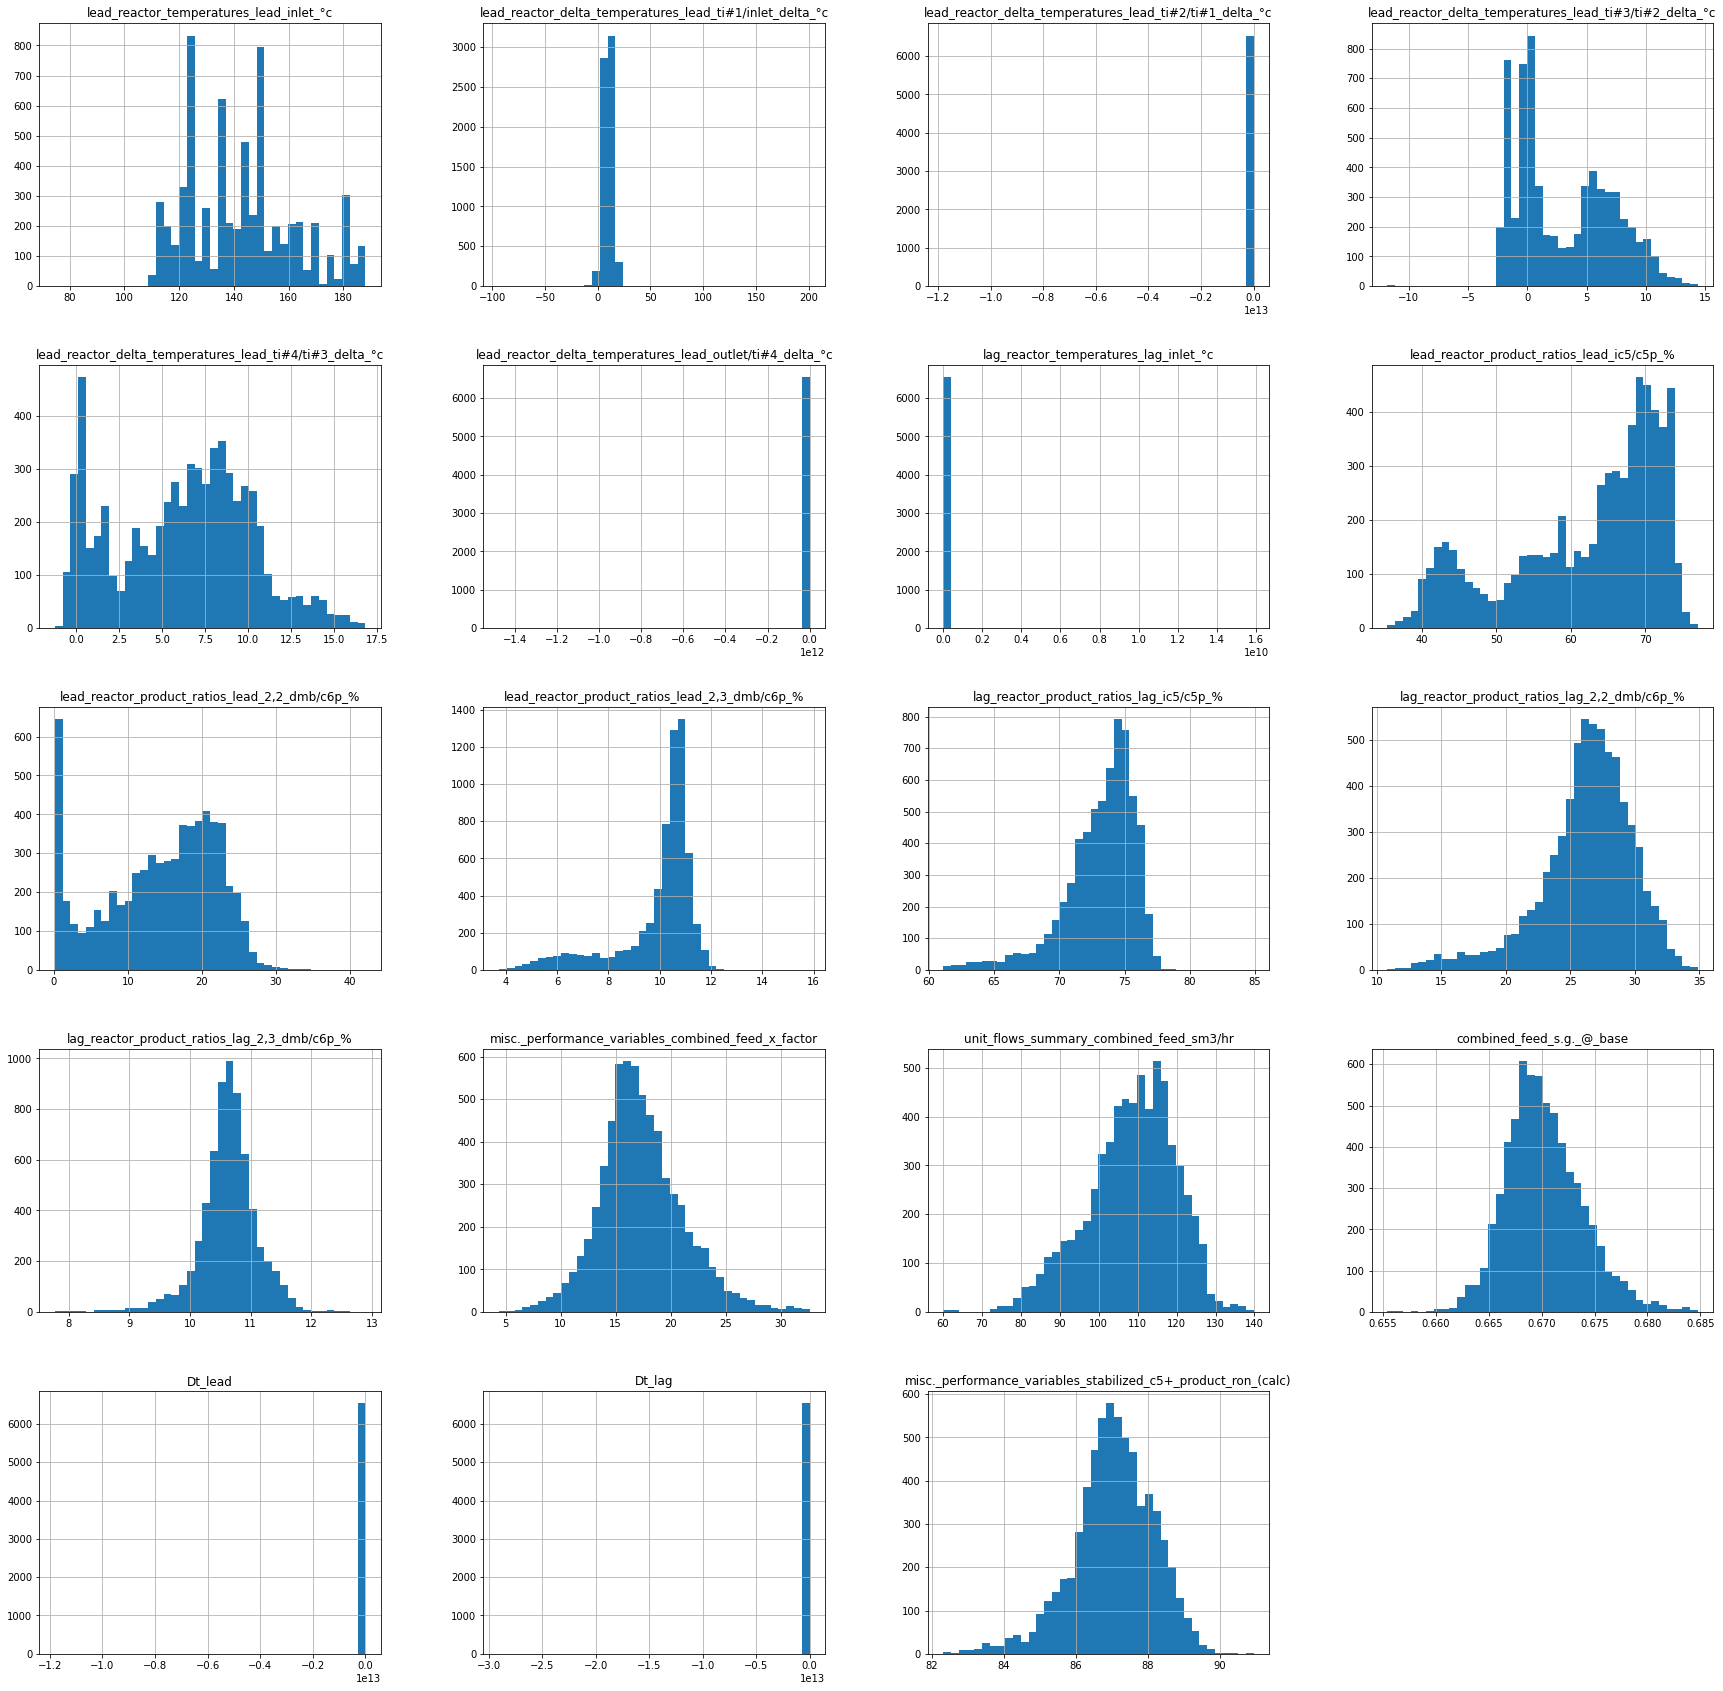

In [28]:
df_new.hist(figsize=(30,30),bins=40);

In [29]:
# trial to convert all features to normally distributed features

In [30]:
y=df_new[df_new.columns[-1:]]

In [31]:
X=df_new[df_new.columns[0:-1]]

In [32]:
X.columns

Index(['lead_reactor_temperatures_lead_inlet_°c',
       'lead_reactor_delta_temperatures_lead_ti#1/inlet_delta_°c',
       'lead_reactor_delta_temperatures_lead_ti#2/ti#1_delta_°c',
       'lead_reactor_delta_temperatures_lead_ti#3/ti#2_delta_°c',
       'lead_reactor_delta_temperatures_lead_ti#4/ti#3_delta_°c',
       'lead_reactor_delta_temperatures_lead_outlet/ti#4_delta_°c',
       'lag_reactor_temperatures_lag_inlet_°c',
       'lead_reactor_product_ratios_lead_ic5/c5p_%',
       'lead_reactor_product_ratios_lead_2,2_dmb/c6p_%',
       'lead_reactor_product_ratios_lead_2,3_dmb/c6p_%',
       'lag_reactor_product_ratios_lag_ic5/c5p_%',
       'lag_reactor_product_ratios_lag_2,2_dmb/c6p_%',
       'lag_reactor_product_ratios_lag_2,3_dmb/c6p_%',
       'misc._performance_variables_combined_feed_x_factor',
       'unit_flows_summary_combined_feed_sm3/hr', 'combined_feed_s.g._@_base',
       'Dt_lead', 'Dt_lag'],
      dtype='object')

#### 3. checking linear regression

#### 4.1.1 linear regression

In [33]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

In [34]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train,y_train)

LinearRegression()

In [35]:
y_predict_train=model.predict(X_train)
y_predict_test=model.predict(X_test)
from sklearn.metrics import r2_score
r2_score(y_train,y_predict_train)

0.7439665099044179

In [36]:
#model.score(X_test,y_test)
y_predict_test=model.predict(X_test)
from sklearn.metrics import r2_score
r2_score(y_test,y_predict_test)

0.7492212899081847

In [37]:
coeffecients_df=pd.DataFrame()
coeffecients_df['features_name']=X.columns
coeffecients_df['Coeffecient']=model.coef_.transpose()

In [38]:
coeffecients_df.sort_values(by=['Coeffecient'],ascending=False)

,features_name,Coeffecient
15,combined_feed_s.g._@_base,5.125464e+01
9,"lead_reactor_product_ratios_lead_2,3_dmb/c6p_%",1.747374e-01
10,lag_reactor_product_ratios_lag_ic5/c5p_%,1.234204e-01
11,"lag_reactor_product_ratios_lag_2,2_dmb/c6p_%",8.658720e-02
8,"lead_reactor_product_ratios_lead_2,2_dmb/c6p_%",3.451888e-02
5,lead_reactor_delta_temperatures_lead_outlet/ti...,1.444395e-02
2,lead_reactor_delta_temperatures_lead_ti#2/ti#1...,1.444395e-02
1,lead_reactor_delta_temperatures_lead_ti#1/inle...,1.202474e-02
7,lead_reactor_product_ratios_lead_ic5/c5p_%,3.373248e-03
0,lead_reactor_temperatures_lead_inlet_°c,2.970378e-03


#### 4.1.2 polynominal regression

In [39]:
from sklearn.preprocessing import PolynomialFeatures
poly_feat = PolynomialFeatures(degree = 2,include_bias=False)
X_poly = poly_feat.fit_transform(X)

In [40]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_poly,y,test_size=0.2)

In [41]:
poly_model = LinearRegression(fit_intercept=False).fit(X_train, y_train)
y_predict_train=poly_model.predict(X_train)
y_predict_test=poly_model.predict(X_test)

In [42]:
from sklearn.metrics import r2_score
r2_score(y_train,y_predict_train)

-5914.032900974725

In [43]:
from sklearn.metrics import r2_score
r2_score(y_test,y_predict_test)

-1.499189714193158e+18

In [44]:
Features_encoding={}
for i,feature in enumerate(X.columns):
    Features_encoding['x'+str(i)]=feature    

In [45]:
coeffecients_df=pd.DataFrame()
coeffecients_df['features_name']=poly_feat.get_feature_names()
coeffecients_df['Coeffecient']=poly_model.coef_.transpose()

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [46]:
coeffecients_df.sort_values(by=['Coeffecient'],ascending=False )

,features_name,Coeffecient
53,x2^2,3.850477e-11
109,x5 x16,3.610202e-11
98,x5^2,3.596681e-11
67,x2 x16,3.356406e-11
2,x2,1.276054e-12
...,...,...
56,x2 x5,-4.766542e-15
5,x5,-4.004908e-13
6,x6,-5.656090e-13
1,x1,-7.212371e-12


In [47]:
Features_encoding['x10']

'lag_reactor_product_ratios_lag_ic5/c5p_%'

#### 5. checking multi colinearity

In [48]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
x=X
vif=pd.DataFrame()
vif['feature']=x.columns
vif['vif']=[variance_inflation_factor(x.values,i) for i in range (x.shape[1])]
vif.sort_values('vif', ascending=False)

/opt/conda/lib/python3.7/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,feature,vif
2,lead_reactor_delta_temperatures_lead_ti#2/ti#1...,inf
5,lead_reactor_delta_temperatures_lead_outlet/ti...,inf
16,Dt_lead,inf
1,lead_reactor_delta_temperatures_lead_ti#1/inle...,8.882598e+08
3,lead_reactor_delta_temperatures_lead_ti#3/ti#2...,2.370708e+08
4,lead_reactor_delta_temperatures_lead_ti#4/ti#3...,2.070939e+08
7,lead_reactor_product_ratios_lead_ic5/c5p_%,3.446890e+01
8,"lead_reactor_product_ratios_lead_2,2_dmb/c6p_%",3.055148e+01
11,"lag_reactor_product_ratios_lag_2,2_dmb/c6p_%",1.501992e+01
10,lag_reactor_product_ratios_lag_ic5/c5p_%,1.232621e+01


In [49]:
X=X[X.columns[~(X.columns.str.contains('combined_feed_s.g._@_base'))]]

In [50]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
x=X
vif=pd.DataFrame()
vif['feature']=x.columns
vif['vif']=[variance_inflation_factor(x.values,i) for i in range (x.shape[1])]
vif.sort_values('vif', ascending=False)

/opt/conda/lib/python3.7/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,feature,vif
2,lead_reactor_delta_temperatures_lead_ti#2/ti#1...,inf
5,lead_reactor_delta_temperatures_lead_outlet/ti...,inf
15,Dt_lead,inf
3,lead_reactor_delta_temperatures_lead_ti#3/ti#2...,4.374033e+08
4,lead_reactor_delta_temperatures_lead_ti#4/ti#3...,3.532406e+08
1,lead_reactor_delta_temperatures_lead_ti#1/inle...,2.950507e+08
7,lead_reactor_product_ratios_lead_ic5/c5p_%,3.438504e+01
8,"lead_reactor_product_ratios_lead_2,2_dmb/c6p_%",3.046575e+01
11,"lag_reactor_product_ratios_lag_2,2_dmb/c6p_%",1.156058e+01
10,lag_reactor_product_ratios_lag_ic5/c5p_%,5.278381e+00


## After removing one column go back to test_split step to reach the maximum score